Загружаем данные
Обработка 12 файлов
Синхронизация (merge_asof, допуск 3600 сек)
Течение рассчитано. Точек: 1283544
Итоговый датасет: 167411 точек
Ковариаты: ['Current', 'Wind_Speed', 'Wind_Angle_Abs', 'Wave_Height', 'Depth', 'Turn_Abs']

Обучение модели.

Параметр             | Уровней  | Границы
--------------------------------------------------------------------------------
Current              | 5        | -1.00 | -0.50 | -0.20 | 0.20
Wind_Speed           | 5        | 6.60 | 12.40 | 19.20 | 26.60
Wind_Angle_Abs       | 5        | 7.00 | 16.00 | 32.00 | 69.00
Wave_Height          | 5        | 0.09 | 0.29 | 0.49 | 1.00
Depth                | 5        | 11.40 | 28.60 | 45.90 | 77.30
Turn_Abs             | 5        | 0.10 | 0.40 | 0.70 | 1.50
--------------------------------------------------------------------------------
Модель обучена. Найдено 2129 режимов.

Рейтинг режимов:
Сравнение расхода при 12.0 узлах в разных условиях:
----------------------------------------------------------

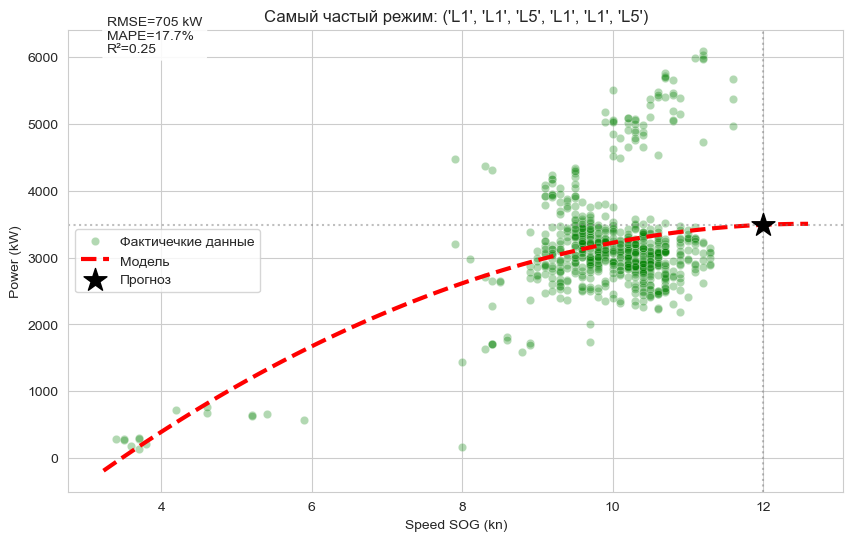

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

data_folder = 'data'
mapping_filename = 'qid_mapping.tsv'

tolerance_sec = 3600 

#количество разбиений
n_bins = 5 

covariates = [
    'Current',    #течение (SOG - STW)
    'Wind_Speed',     
    'Wind_Angle_Abs',  
    'Wave_Height',   
    'Depth',          
    'Turn_Abs'         
]

sensors = {
    'Power': 'Vessel Propeller Shaft Mechanical Power',
    'Speed_SOG': 'Vessel Hull Over Ground Speed',              
    'Speed_STW': 'Vessel Hull Through Water Longitudinal Speed', 
    'Wind_Speed': 'Vessel External Conditions Wind Relative Speed',
    'Wind_Angle': 'Vessel External Conditions Wind Relative Angle',
    'Wave_Height': 'Vessel External Conditions Wave Significant Height(S)',
    'Depth': 'Vessel Hull Relative To Transducer Water Depth',
    'Turn_Rate': 'Vessel Hull Heading Turn Rate'
}

print("Загружаем данные")

try:
    map_df = pd.read_csv(mapping_filename, sep='\t', dtype={'qid_mapping': str})
    map_df['qid_mapping'] = map_df['qid_mapping'].str.strip()
    map_df['quantity_name'] = map_df['quantity_name'].str.strip()
    
    name_to_code = {}
    for key, name in sensors.items():
        rows = map_df[map_df['quantity_name'] == name]
        if not rows.empty:
            name_to_code[rows.iloc[0]['qid_mapping']] = key
    target_codes_list = list(name_to_code.keys())
except Exception as e:
    raise ValueError(f"Ошибка: {e}")

all_files = glob.glob(os.path.join(data_folder, '*.csv'))
df_list = []
print(f"Обработка {len(all_files)} файлов")
for f in all_files:
    try:
        chunk = pd.read_csv(f, header=None, names=['ts', 'code', 'val'], dtype={'code': str, 'val': float})
        chunk['code'] = chunk['code'].str.strip()
        filtered = chunk[chunk['code'].isin(target_codes_list)].copy()
        if not filtered.empty:
            filtered['param'] = filtered['code'].map(name_to_code)
            df_list.append(filtered[['ts', 'param', 'val']])
    except: pass

full_df = pd.concat(df_list, ignore_index=True)
full_df['ts'] = pd.to_datetime(full_df['ts'], format='ISO8601', errors='coerce')
full_df = full_df.sort_values('ts')

print(f"Синхронизация (merge_asof, допуск {tolerance_sec} сек)")
df_main = full_df[full_df['param'] == 'Power'][['ts', 'val']].rename(columns={'val': 'Power'}).dropna().sort_values('ts')
params_to_merge = [k for k in sensors.keys() if k != 'Power']

for param in params_to_merge:
    df_p = full_df[full_df['param'] == param][['ts', 'val']].rename(columns={'val': param}).dropna().sort_values('ts')
    if not df_p.empty:
        df_main = pd.merge_asof(df_main, df_p, on='ts', direction='nearest', tolerance=pd.Timedelta(f'{tolerance_sec}s'))

df_final = df_main.dropna(subset=['Power', 'Speed_SOG']).copy()
df_final = df_final[(df_final['Power'] > 100) & (df_final['Speed_SOG'] > 2)].copy()

#расчет параметров
if 'Speed_STW' in df_final.columns:
    df_final['Current'] = df_final['Speed_SOG'] - df_final['Speed_STW']
    print(f"Течение рассчитано. Точек: {df_final['Current'].notna().sum()}")
else:
    print("Ошибка: Speed_STW не найдена. Течение удаляется.")
    if 'Current' in covariates: covariates.remove('Current')

if 'Wind_Angle' in df_final.columns:
    df_final['Wind_Angle_Abs'] = np.abs(((df_final['Wind_Angle'] + 180) % 360) - 180)

if 'Turn_Rate' in df_final.columns:
    df_final['Turn_Abs'] = df_final['Turn_Rate'].abs()

active_covariates = [c for c in covariates if c in df_final.columns]
df_model = df_final.dropna(subset=active_covariates).copy()

print(f"Итоговый датасет: {len(df_model)} точек")
print(f"Ковариаты: {active_covariates}")
#обучаем модель
print(f"\nОбучение модели.")

bin_boundaries = {}
model_registry = {}
bin_cols = []
labels_template = [f'L{i}' for i in range(1, n_bins + 1)]

for col in active_covariates:
    b_name = f'B_{col}'
    bin_cols.append(b_name)
    
    try:
        out, bins = pd.qcut(df_model[col], q=n_bins, labels=False, retbins=True, duplicates='drop')
        real_count = len(bins) - 1
        current_labels = labels_template[:real_count]
        bins[0] = -np.inf
        bins[-1] = np.inf
        
        df_model[b_name] = pd.cut(df_model[col], bins=bins, labels=current_labels)
        bin_boundaries[col] = {'bins': bins, 'labels': current_labels}
    except:
        out, bins = pd.cut(df_model[col], bins=n_bins, labels=labels_template, retbins=True)
        df_model[b_name] = out
        bin_boundaries[col] = {'bins': bins, 'labels': labels_template}

#отчет
print(f"\n{'Параметр':<20} | {'Уровней':<8} | {'Границы'}")
print("-" * 80)
for col, info in bin_boundaries.items():
    count = len(info['labels'])
    bounds_clean = [f"{b:.2f}" for b in info['bins'][1:-1]]
    bounds_str = " | ".join(bounds_clean)
    print(f"{col:<20} | {count:<8} | {bounds_str}")
print("-" * 80)

#группировка
grouped = df_model.groupby(bin_cols, observed=True)
min_points = 20

for name, group in grouped:
    if len(group) < min_points: continue
    
    X = group['Speed_SOG'].values 
    y = group['Power'].values
    if len(np.unique(X)) < 3: continue 
        
    coeffs = np.polyfit(X, y, 2)
    y_pred = np.polyval(coeffs, X)
    
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred) * 100
    
    model_registry[name] = {'coeffs': coeffs, 'rmse': rmse, 'r2': r2, 'mape': mape, 'sample': group}

print(f"Модель обучена. Найдено {len(model_registry)} режимов.")
print("\nРейтинг режимов:")

#выбираем скорость для прогноза
req_speed = 12.0 

print(f"Сравнение расхода при {req_speed} узлах в разных условиях:")
print("-" * 120)
print(f"{'№':<3} | {'Группа (L1=Min, L5=Max)':<40} | {'Точек':<6} | {'R²':<6} | {'MAPE':<6} | {'RMSE':<6} | {'Power (kW)':<10}")
print("-" * 120)

sorted_groups = sorted(
    model_registry.items(), 
    key=lambda item: len(item[1]['sample']), 
    reverse=True
)
for i, (key, data) in enumerate(sorted_groups[:15]):
    pred_power = np.polyval(data['coeffs'], req_speed)
    r2_str = f"{data['r2']:.3f}"
    print(f"{i+1:<3} | {str(key):<40} | {len(data['sample']):<6} | {r2_str:<6} | {data['mape']:.1f}%  | {data['rmse']:.0f}   | {pred_power:.0f}")
print("-" * 120)

print("\nГрафик самого частого режима")

top_key = sorted_groups[0][0]
top_model = sorted_groups[0][1]
pred = np.polyval(top_model['coeffs'], req_speed)

print(f"Самый частый режим: {top_key}")
print(f"Прогноз: {pred:.0f} кВт")

sample = top_model['sample']
plt.figure(figsize=(10, 6))

sns.scatterplot(data=sample, x='Speed_SOG', y='Power', alpha=0.3, color='green', label='Фактичечкие данные')

x_min = min(sample['Speed_SOG'].min(), req_speed) * 0.95
x_max = max(sample['Speed_SOG'].max(), req_speed) * 1.05
x_line = np.linspace(x_min, x_max, 100)
y_line = np.polyval(top_model['coeffs'], x_line)

plt.plot(x_line, y_line, 'r--', lw=3, label='Модель')
plt.scatter([req_speed], [pred], s=300, marker='*', color='black', zorder=10, label='Прогноз')

plt.axvline(x=req_speed, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=pred, color='gray', linestyle=':', alpha=0.5)

stats = f"RMSE={top_model['rmse']:.0f} kW\nMAPE={top_model['mape']:.1f}%\nR²={top_model['r2']:.2f}"
plt.annotate(stats, xy=(0.05, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="white", alpha=0.9))

plt.title(f"Самый частый режим: {top_key}")
plt.xlabel('Speed SOG (kn)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()